In [1]:
import numpy as np
import matplotlib.pyplot as plt
from testCases import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

np.random.seed(1) #设置一个固定的随机种子，以保证接下来的步骤中我们的结果是一致的。

## 加载数据

X的维度为: (2, 400)
Y的维度为: (1, 400)
数据集里面的数据有：400 个


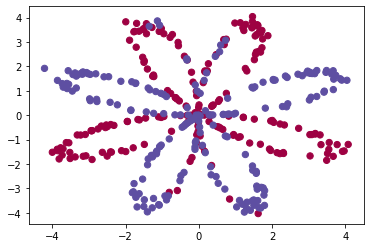

In [2]:
X,Y = load_planar_dataset()
# 可视化数据
plt.scatter(X[0,:], X[1,:], c=np.squeeze(Y), s=40, cmap=plt.cm.Spectral)

shape_X = X.shape
shape_Y = Y.shape
m = Y.shape[1]  # 训练集里面的数量

print ("X的维度为: " + str(shape_X))
print ("Y的维度为: " + str(shape_Y))
print ("数据集里面的数据有：" + str(m) + " 个")

## 查看sklearn的logistic回归的分类效果

In [3]:
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X.T, Y.T)

D:\tech\Anaconda3\envs\pytorch1.4-cuda10.1\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

逻辑回归的准确性： 47 % (正确标记的数据点所占的百分比)


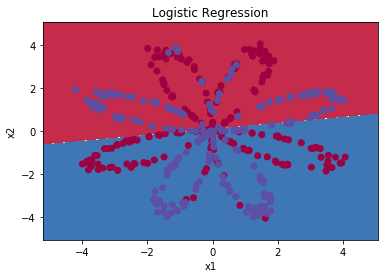

In [4]:
plot_decision_boundary(lambda x: clf.predict(x), X, Y) #绘制决策边界
plt.title("Logistic Regression") #图标题
LR_predictions  = clf.predict(X.T) #预测结果
print ("逻辑回归的准确性： %d " % float((np.dot(Y, LR_predictions) + 
        np.dot(1 - Y,1 - LR_predictions)) / float(Y.size) * 100) +
       "% " + "(正确标记的数据点所占的百分比)")

## 定义神经网络结构&初始化

In [5]:
def layer_sizes(X, Y):
    n_x = X.shape[0]
    n_h = 4 # 隐藏层，硬编码为4
    n_y = Y.shape[0]
    return (n_x,n_h,n_y)

In [6]:
def initialize_parameters(n_x, n_h, n_y):
    """
    参数：
        n_x - 输入层节点的数量
        n_h - 隐藏层节点的数量
        n_y - 输出层节点的数量
    
    返回：
        parameters - 包含参数的字典：
            W1 - 权重矩阵,维度为（n_h，n_x）
            b1 - 偏向量，维度为（n_h，1）
            W2 - 权重矩阵，维度为（n_y，n_h）
            b2 - 偏向量，维度为（n_y，1）

    """
    np.random.seed(2)
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros(shape=(n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros(shape=(n_y, 1))
    
    parameters = {"W1" : W1,
                  "b1" : b1,
                  "W2" : W2,
                  "b2" : b2 }
    return parameters

## 主循环

In [23]:
def forward_propagation(X, parameters):
    """
    参数：
         X - 维度为（n_x，m）的输入数据。
         parameters - 初始化函数（initialize_parameters）的输出
    
    返回：
         A2 - 使用sigmoid()函数计算的第二次激活后的数值
         cache - 包含“Z1”，“A1”，“Z2”和“A2”的字典类型变量
     """
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    #A2 = np.maximum(Z2,0)
    
    assert(A2.shape == (1, X.shape[1]))
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    return (A2,cache)


In [24]:
def compute_cost(A2, Y):
    """
    计算交叉熵成本，
    
    参数：
         A2 - 使用sigmoid()函数计算的第二次激活后的数值
         Y - "True"标签向量,维度为（1，数量）
         parameters - 一个包含W1，B1，W2和B2的字典类型的变量
    
    返回：
         成本
    """
    m = Y.shape[1]
    logprobs = np.multiply(Y, np.log(A2)) + np.multiply(1-Y, np.log(1-A2))
    cost = -np.sum(logprobs) / m
    cost = float(np.squeeze(cost))
    
    assert(isinstance(cost,float))
    return cost

In [25]:
def backward_propagation(parameters, cache, X, Y):
    m = X.shape[1]
    
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
    A1 = cache["A1"]
    A2 = cache["A2"]
    
    # 计算导数
    dZ2 = A2 - Y
    dW2 = np.dot(dZ2,A1.T) / m
    db2 = np.sum(dZ2, axis=1, keepdims = True) / m
    dZ1 = np.multiply(np.dot(W2.T,dZ2), (1 - np.power(A1, 2)))
    dW1 = np.dot(dZ1,X.T) / m
    db1 = np.sum(dZ1, axis=1, keepdims = True) / m
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2 }
    return grads

In [26]:
def update_parameters(parameters, grads, learning_rate=1.2):
    """
    参数：
     parameters - 包含参数的字典类型的变量。
     grads - 包含导数值的字典类型的变量。
     learning_rate - 学习速率
    
    返回：
     parameters - 包含更新参数的字典类型的变量。
    """
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {"W1" : W1,
                  "b1" : b1,
                  "W2" : W2,
                  "b2" : b2 }
    return parameters

## 整合到模型中

In [27]:
def nn_model(X, Y, n_h, num_iterations, print_cost=False):
    """
    参数：
        X - 数据集,维度为（2，示例数）
        Y - 标签，维度为（1，示例数）
        n_h - 隐藏层的数量
        num_iterations - 梯度下降循环中的迭代次数
        print_cost - 如果为True，则每1000次迭代打印一次成本数值
    
    返回：
        parameters - 模型学习的参数，它们可以用来进行预测。
    """
    np.random.seed(3) #指定随机种子
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    for i in range(num_iterations):
        A2, cache = forward_propagation(X, parameters)
        cost = compute_cost(A2, Y)
        grads = backward_propagation(parameters, cache, X, Y)
        parameters = update_parameters(parameters, grads, learning_rate=0.5)
        if print_cost:
            if i % 1000 == 0:
                print("iteration:",str(i)," cost:",str(cost))
    return parameters

## 预测

In [28]:
def predict(parameters, X):
    A2 , cache = forward_propagation(X,parameters)
    predictions = np.round(A2)
    
    return predictions

## 正式运行

iteration: 0  cost: 0.6930480201239823
iteration: 1000  cost: 0.3098018601352803
iteration: 2000  cost: 0.2924326333792647
iteration: 3000  cost: 0.2833492852647412
iteration: 4000  cost: 0.27678077562979253
iteration: 5000  cost: 0.2634715508859341
iteration: 6000  cost: 0.24204413129940774
iteration: 7000  cost: 0.23552486626608768
iteration: 8000  cost: 0.2314096450985428
iteration: 9000  cost: 0.22846408048352365
准确率: 90%


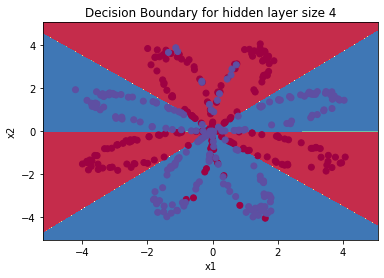

In [29]:
parameters = nn_model(X, Y, n_h=4, num_iterations=10000, print_cost=True)

#绘制边界
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

predictions = predict(parameters, X)
print ('准确率: %d' % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100) + '%')

## 修改隐藏层节点数量test

隐藏层的节点数量： 1  ，准确率: 67.25 %
隐藏层的节点数量： 2  ，准确率: 66.5 %
隐藏层的节点数量： 3  ，准确率: 89.25 %
隐藏层的节点数量： 4  ，准确率: 90.0 %
隐藏层的节点数量： 5  ，准确率: 89.75 %
隐藏层的节点数量： 20  ，准确率: 90.0 %
隐藏层的节点数量： 50  ，准确率: 89.75 %


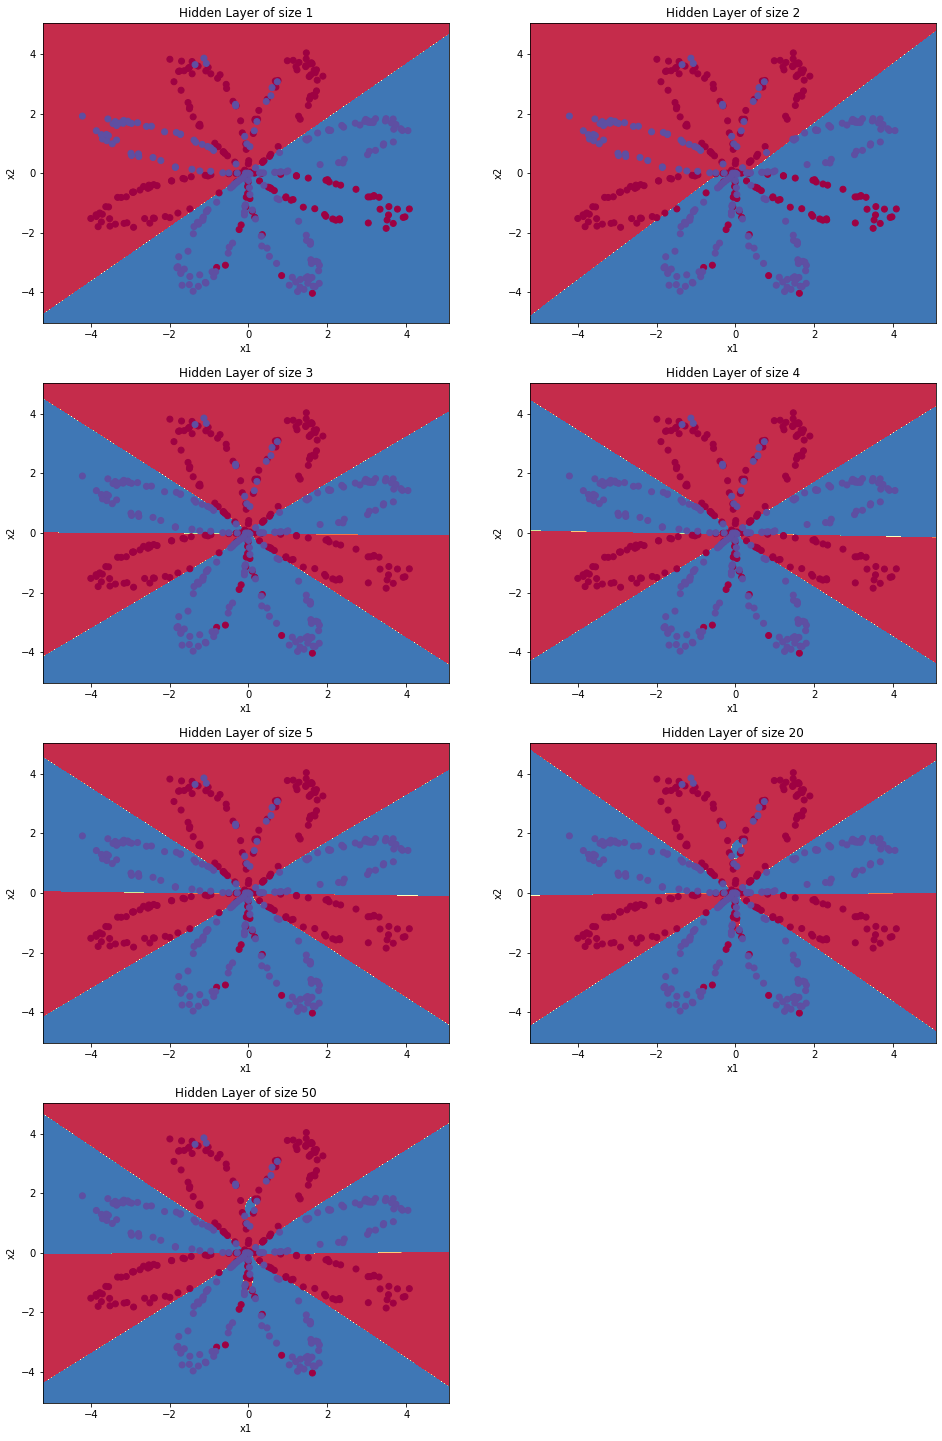

In [30]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50] #隐藏层数量
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i + 1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations=5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100)
    print ("隐藏层的节点数量： {}  ，准确率: {} %".format(n_h, accuracy))
